<a href="https://colab.research.google.com/github/maximloginov/self_isolation/blob/colab/Isolation_and_Game_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

np.random.seed(42)

In [2]:
class Human():
    def __init__(self):
        self.happiness = np.random.randint(0, 15)
        self.state = 'H' # H for healthy, S for sick, R for resistant
        
    def __repr__(self):
        return '{}_{}'.format(self.state, self.happiness)

In [3]:
class City():
    def __init__(self, population, recovery_probability):
        self.population = population
        self.recovery_probability = recovery_probability
        self.people = np.array([Human() for _ in range(self.population)])
        self.n_sick = 0
        self.n_healthy = self.population
    
    def __repr__(self):
        return str(self.people)
    
    def get_happiness(self):
        return np.array([human.happiness for human in self.people])
    
    def healthy_per_sick(self):
        if self.n_sick == 0:
            return self.population
        else:
            return (self.population - self.n_sick) / self.n_sick
    
    def n_go_out(self):
        return len(list(filter(lambda x: x.happiness < self.healthy_per_sick(), self.people)))

    def make_people_sick(self, n):
        indexes = np.random.randint(0, self.population, size=n)
        for human in self.people[indexes]:
            human.state = 'S'
            self.n_sick += 1
            self.n_healthy -= 1
    
    def next_day(self):
        for human in self.people:
            if human.state == 'S' and (np.random.random() < self.recovery_probability):
                human.state = 'R'
                self.n_sick -= 1
                continue
                
            if human.state == 'R':
                human.happiness += 1
                continue
            
            # For healthy people we have to decide if they go out or stay home
            if human.state == 'H' and \
                (self.n_sick == 0 or human.happiness < self.healthy_per_sick()):  # Happiness is low enough to go out
                if np.random.random() < self.n_sick / self.population:
                    # Human is sick now
                    human.state = 'S'
                    human.happiness = 0
                    self.n_sick += 1
                    self.n_healthy -= 1
                else:
                    # Human is not sick and a little bit happier
                    human.happiness += 1
                    
            else: # Stay home and become less happy
                human.happiness -= 1
                
        
    def isolated_next_day(self):
        for human in self.people:
            if human.state == 'S' and (np.random.random() < self.recovery_probability):
                human.state = 'R'
                self.n_sick -= 1
                continue  
            else:
                human.happiness -= 1
                
    def print_characteristics(self):
        print('Healthy:', self.n_healthy)
        print('Sick:', self.n_sick)
        print('Resistant:', self.population - self.n_sick - self.n_healthy)
        print('Walkers:', self.n_go_out())

In [4]:
city = City(10, .1)
city

[H_6 H_3 H_12 H_14 H_10 H_7 H_12 H_4 H_6 H_9]

In [5]:
city.make_people_sick(2)
city

[H_6 H_3 S_12 H_14 H_10 H_7 S_12 H_4 H_6 H_9]

In [6]:
for day in range(15):
    print('Day:', day)
    city.print_characteristics()
    city.next_day()
    print()
    
city.print_characteristics()

Day: 0
Healthy: 8
Sick: 2
Resistant: 0
Walkers: 1

Day: 1
Healthy: 7
Sick: 3
Resistant: 0
Walkers: 1

Day: 2
Healthy: 7
Sick: 2
Resistant: 1
Walkers: 1

Day: 3
Healthy: 7
Sick: 2
Resistant: 1
Walkers: 4

Day: 4
Healthy: 6
Sick: 3
Resistant: 1
Walkers: 4

Day: 5
Healthy: 5
Sick: 4
Resistant: 1
Walkers: 4

Day: 6
Healthy: 4
Sick: 5
Resistant: 1
Walkers: 4

Day: 7
Healthy: 4
Sick: 4
Resistant: 2
Walkers: 5

Day: 8
Healthy: 3
Sick: 4
Resistant: 3
Walkers: 6

Day: 9
Healthy: 3
Sick: 3
Resistant: 4
Walkers: 7

Day: 10
Healthy: 2
Sick: 4
Resistant: 4
Walkers: 7

Day: 11
Healthy: 1
Sick: 5
Resistant: 4
Walkers: 6

Day: 12
Healthy: 1
Sick: 4
Resistant: 5
Walkers: 6

Day: 13
Healthy: 1
Sick: 3
Resistant: 6
Walkers: 7

Day: 14
Healthy: 1
Sick: 3
Resistant: 6
Walkers: 6

Healthy: 0
Sick: 3
Resistant: 7
Walkers: 6


In [7]:
N_PEOPLE = 1000
N_DAYS = 100
RECOVERY_PROBABILITY = 1/14
SICK_PEOPLE_AT_DAY_0 = 1

In [8]:
sicks = []
healthy = []
resistants = []
means = []
mins = []
maxes = []
outs = []

for _ in tqdm(range(1000)):

    city = City(N_PEOPLE, RECOVERY_PROBABILITY)
    city.make_people_sick(SICK_PEOPLE_AT_DAY_0)

    sick_people = [city.n_sick]
    healthy_people = [city.n_healthy]
    resistant_people = [city.population - city.n_sick - city.n_healthy]

    mean_happiness = [city.get_happiness().mean()]
    min_happiness = [city.get_happiness().min()]
    max_happiness = [city.get_happiness().max()]
    n_out = [city.n_go_out()]

    for day in range(N_DAYS):
        city.next_day()

        sick_people.append(city.n_sick)
        healthy_people.append(city.n_healthy)
        resistant_people.append(city.population - city.n_sick - city.n_healthy)

        mean_happiness.append(city.get_happiness().mean())
        min_happiness.append(city.get_happiness().min())
        max_happiness.append(city.get_happiness().max())
        n_out.append(city.n_go_out())
        

    sicks.append(sick_people)
    healthy.append(healthy_people)
    resistants.append(resistant_people)
    means.append(mean_happiness)
    mins.append(min_happiness)
    maxes.append(max_happiness)
    outs.append(n_out)
    
sicks = np.array(sicks)
healthy = np.array(healthy)
resistants = np.array(resistants)
means = np.array(means)
mins = np.array(mins)
maxes = np.array(maxes)
outs = np.array(outs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
without_isolation = pd.DataFrame([sicks.mean(axis=0),
                                  healthy.mean(axis=0),
                                  resistants.mean(axis=0),
                                  means.mean(axis=0),
                                  mins.mean(axis=0),
                                  maxes.mean(axis=0),
                                  outs.mean(axis=0)]).T

without_isolation.columns = ['sick', 'healthy', 'resistant', 'mean_happiness',
                             'min_happiness', 'max_happiness', 'walkers']
without_isolation

,sick,healthy,resistant,mean_happiness,min_happiness,max_happiness,walkers
0,1.000,999.000,0.000,6.991264,0.000,14.000,1000.000
1,2.507,997.411,0.082,7.976796,0.277,15.000,1000.000
2,6.597,993.142,0.261,8.933439,-0.417,16.000,999.806
3,16.695,982.593,0.712,9.812194,-1.254,16.997,992.317
4,37.346,960.774,1.880,10.471965,-2.061,17.941,890.344
...,...,...,...,...,...,...,...
96,4.211,81.068,914.721,53.136272,-65.416,94.791,999.634
97,3.909,81.067,915.024,54.128108,-65.918,95.791,999.742
98,3.641,81.066,915.293,55.120507,-66.411,96.791,999.803
99,3.376,81.065,915.559,56.113438,-66.881,97.791,999.883


In [10]:
without_isolation.to_csv('Without_isolation_1000.csv', index=False)

(0.0, 100.0)

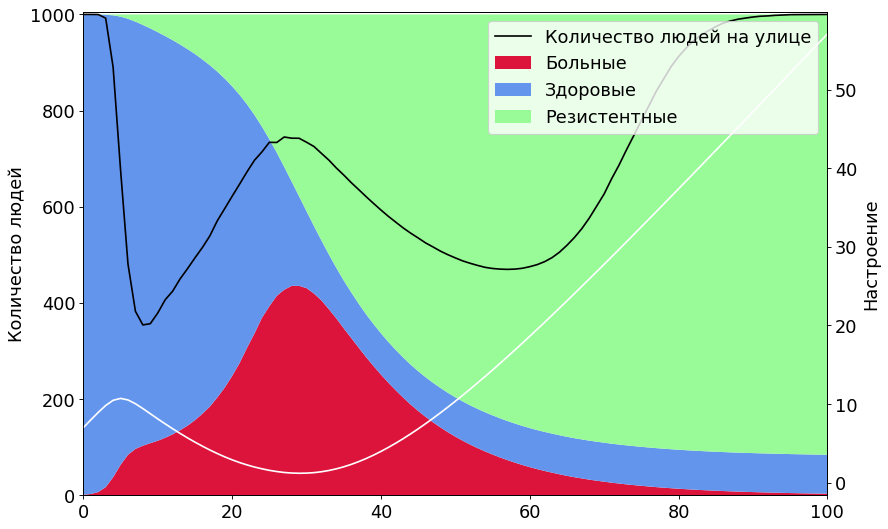

In [11]:
days = np.arange(without_isolation.shape[0])
fig, ax1 = plt.subplots(1,1,figsize=(12,8), dpi= 80)

ax1.stackplot(days, np.vstack([without_isolation['sick'], without_isolation['healthy'], without_isolation['resistant']]), 
              labels=['Больные', 'Здоровые', 'Резистентные'], colors=['crimson', 'cornflowerblue', 'palegreen'])
ax1.set_ylabel('Количество людей')
ax1.set_ylim(0, N_PEOPLE+5)
ax1.plot(without_isolation['walkers'], label='Количество людей на улице', c='black')
plt.legend(loc='upper right')

ax2 = ax1.twinx()  # Same x-axis
ax2.plot(days, without_isolation['mean_happiness'], label='Среднее настроение', c='white')
ax2.set_ylabel('Настроение')


plt.xlim(0, N_DAYS)

In [12]:
SICK_THRESHOLD = .1

sicks = []
healthy = []
resistants = []
means = []
mins = []
maxes = []
outs = []

isolation_on = False

isolation_starts = []
isolation_ends = []

for day in tqdm(range(1000)):

    city = City(N_PEOPLE, RECOVERY_PROBABILITY)
    city.make_people_sick(SICK_PEOPLE_AT_DAY_0)

    sick_people = [city.n_sick]
    healthy_people = [city.n_healthy]
    resistant_people = [city.population - city.n_sick - city.n_healthy]

    mean_happiness = [city.get_happiness().mean()]
    min_happiness = [city.get_happiness().min()]
    max_happiness = [city.get_happiness().max()]
    n_out = [city.n_go_out()]

    for day in range(N_DAYS):
        if city.n_sick < SICK_THRESHOLD*city.population and not isolation_on:
            city.next_day()
        else:
            if not isolation_on:
                isolation_on = True
                isolation_starts.append(day)
            if city.n_sick == 0:
                isolation_on = False
                isolation_ends.append(day)

            city.isolated_next_day()

        sick_people.append(city.n_sick)
        healthy_people.append(city.n_healthy)
        resistant_people.append(city.population - city.n_sick - city.n_healthy)

        mean_happiness.append(city.get_happiness().mean())
        min_happiness.append(city.get_happiness().min())
        max_happiness.append(city.get_happiness().max())
        
        if isolation_on:
            n_out.append(0)
        else:
            n_out.append(city.n_go_out())
        

    sicks.append(sick_people)
    healthy.append(healthy_people)
    resistants.append(resistant_people)
    means.append(mean_happiness)
    mins.append(min_happiness)
    maxes.append(max_happiness)
    outs.append(n_out)
    
sicks = np.array(sicks)
healthy = np.array(healthy)
resistants = np.array(resistants)
means = np.array(means)
mins = np.array(mins)
maxes = np.array(maxes)
outs = np.array(outs)

isolation_starts = np.array(isolation_starts)
isolation_ends = np.array(isolation_ends)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
with_isolation = pd.DataFrame([sicks.mean(axis=0),
                                  healthy.mean(axis=0),
                                  resistants.mean(axis=0),
                                  means.mean(axis=0),
                                  mins.mean(axis=0),
                                  maxes.mean(axis=0),
                                  outs.mean(axis=0)]).T

with_isolation.columns = ['sick', 'healthy', 'resistant', 'mean_happiness',
                             'min_happiness', 'max_happiness', 'walkers']
with_isolation

,sick,healthy,resistant,mean_happiness,min_happiness,max_happiness,walkers
0,1.000,999.000,0.000,7.004178,0.000,14.000,1000.000
1,2.560,997.359,0.081,7.845613,0.169,14.856,928.000
2,6.516,993.223,0.261,8.659381,-0.526,15.712,932.000
3,16.735,982.572,0.693,9.400709,-1.348,16.576,926.145
4,36.533,961.589,1.878,9.931088,-2.180,17.359,823.573
...,...,...,...,...,...,...,...
96,0.098,895.414,104.488,-21.173173,-34.444,-13.739,898.000
97,0.091,895.414,104.495,-20.377166,-33.648,-12.943,909.000
98,0.083,895.414,104.503,-19.559158,-32.830,-12.125,914.000
99,0.076,895.414,104.510,-18.731151,-32.001,-11.297,922.000


In [14]:
with_isolation.to_csv('with_isolation_1000.csv', index=False)

(0.0, 100.0)

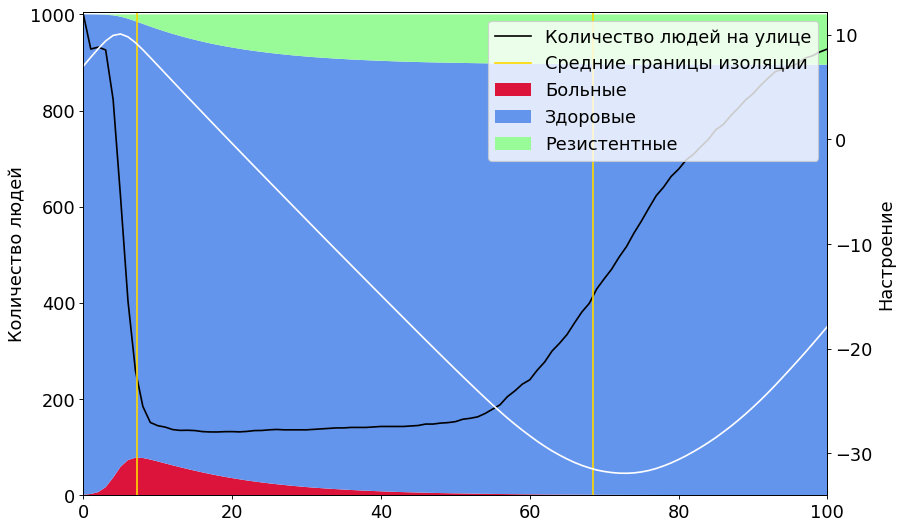

In [15]:
days = np.arange(with_isolation.shape[0])
fig, ax1 = plt.subplots(1,1,figsize=(12,8), dpi= 80)

ax1.stackplot(days, np.vstack([with_isolation['sick'], with_isolation['healthy'], with_isolation['resistant']]), 
              labels=['Больные', 'Здоровые', 'Резистентные'], colors=['crimson', 'cornflowerblue', 'palegreen'])
ax1.set_ylabel('Количество людей')
ax1.set_ylim(0, N_PEOPLE+5)
ax1.plot(with_isolation['walkers'], label='Количество людей на улице', c='black')
ax1.plot([isolation_starts.mean(), isolation_starts.mean()], [0, N_PEOPLE+5], c='gold', 
         label='Средние границы изоляции')
ax1.plot([isolation_ends.mean(), isolation_ends.mean()], [0, N_PEOPLE+5], c='gold')
plt.legend(loc='upper right')

ax2 = ax1.twinx()  # Same x-axis
ax2.plot(days, with_isolation['mean_happiness'], label='Среднее настроение', c='white')
ax2.set_ylabel('Настроение')



plt.xlim(0, N_DAYS)

In [16]:
isolation_ends.mean() - isolation_starts.mean()

61.36491228070175